## Facial Recognition
The first cell represents necessary helper functions for the facial recognition class to load the database.  Run this first.

In [1]:
import numpy as np
from scipy import linalg as la
from os import walk
from scipy.ndimage import imread
from matplotlib import pyplot as plt
from random import sample
import random
%matplotlib inline

original_dim = (200,180)
            
def getFaces(path="./faces94"):
    """Traverse the directory specified by 'path' and return an array containing one column vector per subdirectory.
    For the faces94 dataset, this gives an array with just one column for each
    face in the dataset. Each column corresponds to a flattened grayscale image.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in walk(path):
        for f in filenames:
            if f[-3:]=="jpg": # only get jpg images
                # load image, convert to grayscale, flatten into vector
                face = imread(dirpath+"/"+f).mean(axis=2).ravel()
                faces.append(face)
                break
    # put all the face vectors column-wise into a matrix.
    F = np.array(faces).T
    return F

def sampleFaces(n_tests,path = "./faces94") :
    """Return an array containing a sample of n_tests images contained
    in the path as flattened images in the columns of the output.
    """
    files = []
    for (dirpath, dirnames, filenames) in walk(path):
        for f in filenames:
            if f[-3:]=="jpg": # only get jpg images
                files.append(dirpath+"/"+f)
    #Get a sample of the images
    test_files = sample(files, n_tests)
    #Flatten and average the pixel values
    images = np.array([imread(f).mean(axis=2).ravel() for f in test_files]).T
    return images

def display(F) :
    """
    Displays the provided face
    
    Input : F
        A single numpy array (36000,1) corresponding to a flattened image.
    """
    f = F.reshape((200,180))
    plt.imshow(f,cmap="gray")

### Helper Tests
The following is test code for the helper functions. It gets a random image from our database to display

(36000, 153)


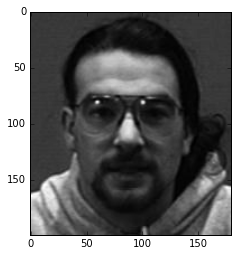

In [2]:
F = getFaces()
print F.shape
f = sampleFaces(1)
display(f)

### Facial Recognition Program
This is the actual code for the facial recognition to work.  It creates your database upon intialization, and then calculates what's necessary to optimize speed for recognizing a specific image.

In [3]:
class FacialRec:
    ##########Members##########
    #   F, mu, Fbar, and U
    ###########################
    def __init__(self,path):
        #Grabs the dataset (images) of persons in the database.
        self.initFaces(path)
        #Finds common features to every individual in the database.
        self.initMeanImage()
        #Creates a photo of unique characteristics for each individual in database.
        self.initDifferences()
        #Creates images to quickly recreate images for faster testing.
        self.initEigenfaces()
    def initFaces(self, path):
        #Uses first helperfunction.
        self.F = getFaces(path)
    def initMeanImage(self):
        #Averages the faces and saves the image as the variable mu.
        self.mu = sum([self.F[:,i] for i in xrange(self.F.shape[1])])/float(self.F.shape[1])
    def initDifferences(self):
        #Finds unique characteristics for each individual and saves them as Fbar.
        self.Fbar = np.copy(self.F)
        for i in xrange(self.Fbar.shape[1]) :
            self.Fbar[:,i] -= self.mu
    def initEigenfaces(self):
        #Calculates the "Eigen Faces" (fastest ways to recreate a specific image).
        self.eigen_faces,s,Vh = la.svd(self.Fbar,full_matrices=False)
    def project(self, A, s=38):
        #Allows you to use a smaller number of eigenfaces to increase speed.
        if s > self.eigen_faces.shape[1] :
            s = self.eigen_faces.shape[1]+1
        return np.dot(self.eigen_faces[:,:s].T,A)
    def findNearest(self, image, s=38):
        #Finds the image closest to the one presented.
        Fhat = np.zeros((s,self.Fbar.shape[1]))
        for i in xrange(self.Fbar.shape[1]) :
            Fhat[:,i] = self.project(self.Fbar[:,i],s)
        Ghat = np.zeros_like(Fhat)
        for i in xrange(image.shape[1]) :
            Ghat[:,i] = self.project(image[:,i] - self.mu,s)
        index = []
        for i in xrange(image.shape[1]) :
            index.append(np.argmin([np.linalg.norm(Fhat[:,x]-Ghat[:,i]) for x in xrange(Fhat.shape[1])]))
        return index

Displays the mean face of the data set.

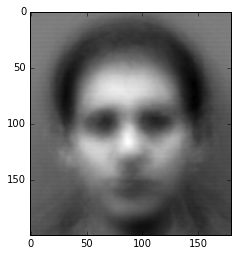

In [4]:
F = FacialRec("./faces94")
display(F.mu)

Shows a random face minus the mean face.

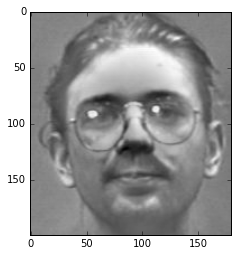

In [5]:
r = random.randint(0,153)
display(F.Fbar[:,r])

A display of the first eigenface afte the SVD decomposition.

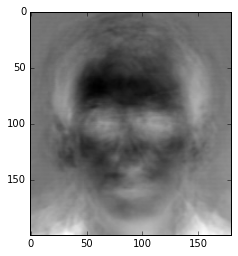

In [6]:
display(F.eigen_faces[:,0])

Uses the first 19 eigenfaces to attempt to recreate the first image in Fbar (mean shifted).

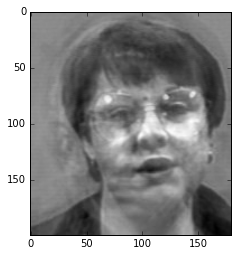

In [7]:
face = np.dot(F.eigen_faces[:,:19],F.project(F.Fbar[:,0],19))
#Add back in the mean face
face += F.mu
display(face)

Testing facial recognition system with samplefaces function.

'\nplt.subplot(423)\ndisplay(faces[:,1])\nplt.subplot(424)\ndisplay(F.F[:,results[1]])\nplt.subplot(425)\ndisplay(faces[:,2])\nplt.subplot(426)\ndisplay(F.F[:,results[2]])\nplt.subplot(427)\ndisplay(faces[:,3])\nplt.subplot(428)\ndisplay(F.F[:,results[3]])\n'

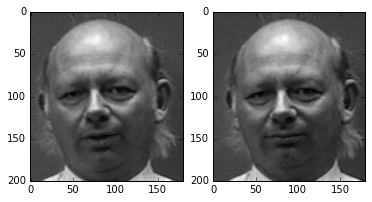

In [11]:
faces = sampleFaces(4)
results = F.findNearest(faces,19)
plt.subplot(121)
display(faces[:,0])
plt.subplot(122)
display(F.F[:,results[0]])
"""
plt.subplot(423)
display(faces[:,1])
plt.subplot(424)
display(F.F[:,results[1]])
plt.subplot(425)
display(faces[:,2])
plt.subplot(426)
display(F.F[:,results[2]])
plt.subplot(427)
display(faces[:,3])
plt.subplot(428)
display(F.F[:,results[3]])
"""